## Functions used in our analysis.

In [2]:
def replacer(val):
    """
    A simple function to introduce bias into our SARIMA Model.
    """
    if val<15:
        val=0
    return val

In [3]:
def check_AIC_BIC(train):
    """
    A function to perform grid search and return a list  of models and their AIC,BIC and parameter values.
    """
    p=d=q=range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
    warnings.filterwarnings("ignore") 
    model_aic_list=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                model_aic_list.append([param,param_seasonal,results.aic,results.bic])
    return model_aic_list

In [4]:
def test_stationarity(timeseries):
    """
    A function to check  for stationariety of our data and to report it in a conciese manner.
    """
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dfoutput[0]<dfoutput[4]

In [5]:
def FTS_replacer(val):
    """
    A simple function to introduce bias into our FuzzyTimeSeries Model.
    """
    val=val-15
    if val<15:
        val=0
    return val
    

In [6]:
def SARIMAX_model(train,test,order,sorder):
    """
    A pipeline function that takes in the parameters, train and test data. Forecasts the time series for 60 steps or 5 years.
    """
    model=SARIMAX(train,order=order,seasonal_order=sorder,enforce_stationarity=False,enforce_invertibility=False)
    fitted=model.fit(disp=False)
    forecasts=fitted.forecast(60)
    RMSE=np.sqrt(mean_squared_error(forecasts,test))
    print('RMSE: {}'.format(RMSE))
    plt.figure(figsize=(12, 6))
    plt.title('Rainfall Forecast', fontsize=30)
    plt.plot((forecasts), label='Forecast')
    plt.plot((test), label='Test')
    plt.legend(fontsize=25)
    return forecasts.resample('Y').sum()

## "Some" Imports

In [7]:
import math
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.special import boxcox1p,inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyFTS.data import Enrollments
from pyFTS.common import Transformations
from pyFTS.partitioners import Grid,CMeans,Entropy,FCM
from pyFTS.common import Membership as mf
from pyFTS.models import chen
from pyFTS.models.ensemble import ensemble
from pyFTS.models.pwfts import ProbabilisticWeightedFTS
from pyFTS.models.hofts import HighOrderFTS,WeightedHighOrderFTS
from pyFTS.models.nonstationary import partitioners as nspart
from pyFTS.models.nonstationary import nsfts
from pyFTS.models.incremental import TimeVariant
from pyFTS.models.incremental import IncrementalEnsemble,TimeVariant
from stldecompose import decompose, forecast
% matplotlib inline

## Objectives:

### Predicting rainfall for the state of Telangana for the years 2018-2024.




## Methods Used:

### Sarimax and Fuzzytime series.


In [8]:
Telangana=pd.read_excel(r'C:\Users\MUKU\Desktop\Python\Data sets\FHD Data sets\Rain Data\Telangana.xlsx')

In [9]:
Tdf=Telangana.set_index(Telangana['Date']).drop(['Date'],axis=1)

In [16]:
Tdf

,Rainfall
Date,
1901-01-01,6.9
1901-02-01,41.8
1901-03-01,7.8
1901-04-01,45.2
1901-05-01,22.0
1901-06-01,123.6
1901-07-01,237.8
1901-08-01,177.2
1901-09-01,77.7


## We need to check for stationarity of our data. To do so we need to do a Dickey-Fuller Test and see if our data meets certain criterias.

### Criterias:
-  p-value must be less than 0.05.


-  The test statistic value should be lower than the critical value at 10%.

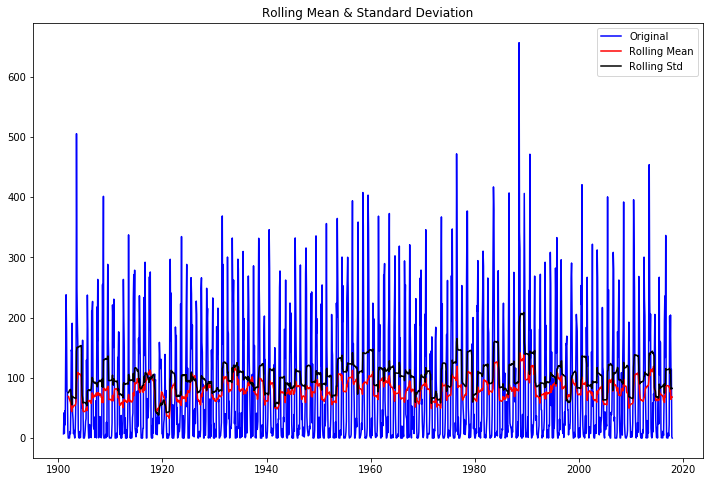

Results of Dickey-Fuller Test:
Test Statistic                -5.887226e+00
p-value                        2.981854e-07
#Lags Used                     2.400000e+01
Number of Observations Used    1.379000e+03
Critical Value (1%)           -3.435101e+00
Critical Value (5%)           -2.863638e+00
Critical Value (10%)          -2.567887e+00
dtype: float64


True

In [10]:
test_stationarity(Tdf['Rainfall'])

### Here we can see that our data meets the test criteria. This means that we will not need to transform our data as it is already stationary.

#### What to do if the data was not stationary?

-  We would have to try out different transformations.
-  Repeat the Dickey-Fuller Test and re check the criterias until they are satisfied.

**Common Transformations:**

1. First Difference

2. Seasonal Difference

3. BoxCox Power Transformation.

4. Log,Squareroot etc.

## Visualising the rain data trend and distribution

### Observed line

Text(0.5, 1.0, 'Rain percipitation data for Telangana')

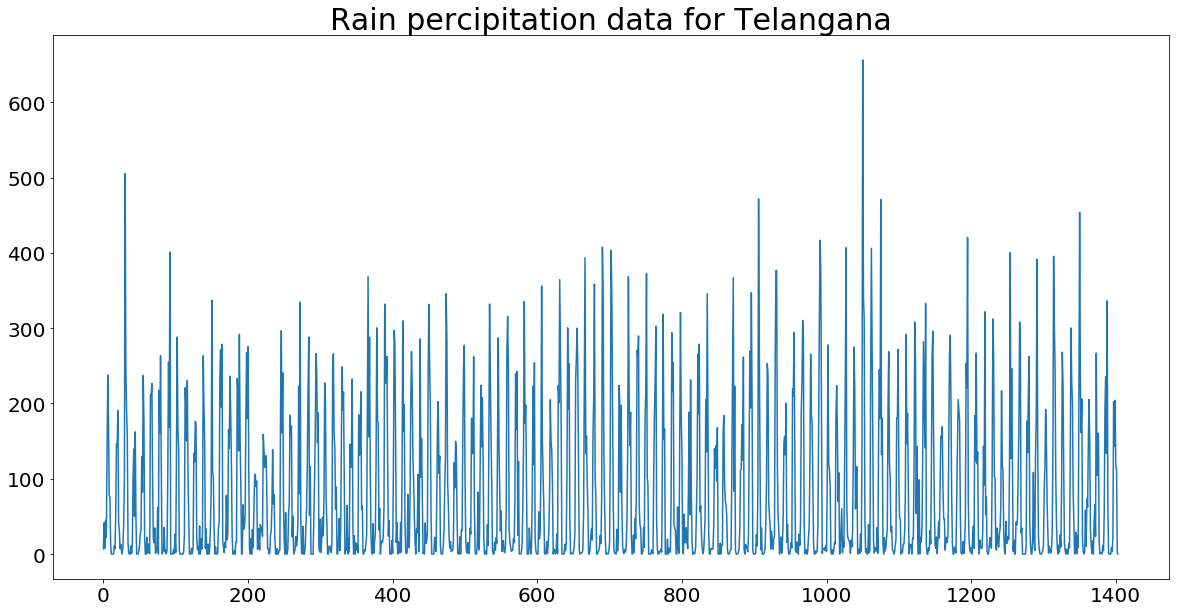

In [11]:
Telangana['Rainfall'].plot(figsize=(20, 10), fontsize=20)
plt.title('Rain percipitation data for Telangana', fontsize=30)

### Rain Percipitation Distribution

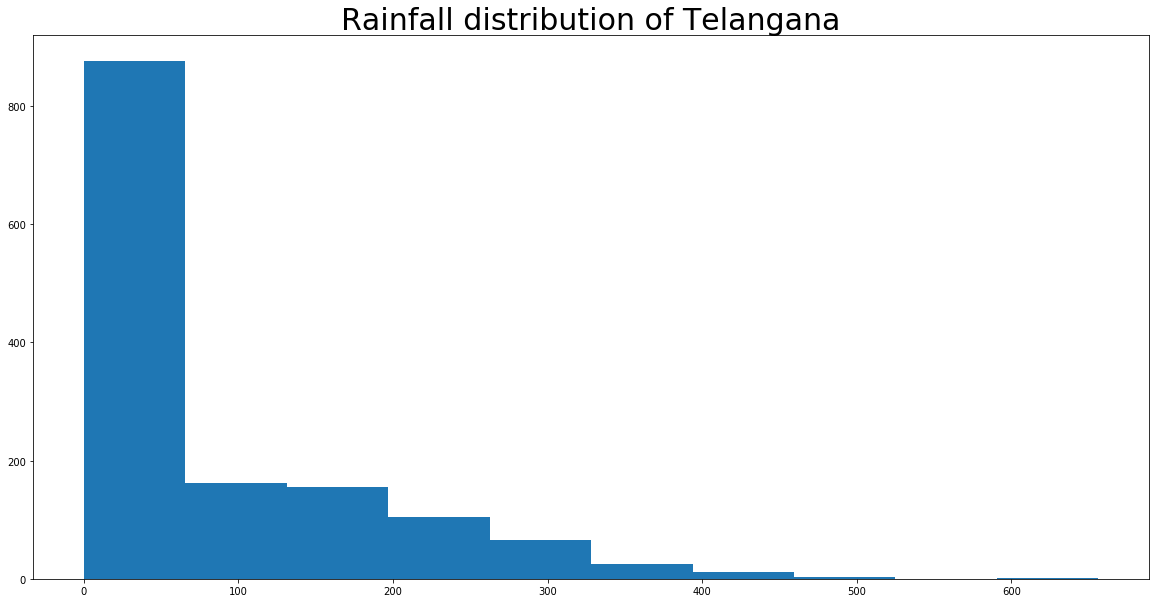

In [12]:
plt.figure(figsize=(20,10))
histogram=plt.hist(Tdf['Rainfall'])
title=plt.title('Rainfall distribution of Telangana',fontsize=30)

## We Decompose our data into 3 categories to further understand what we observe from the data.
### Trend:


-  This basically gives us an idea of the change in variance and mean of our trend.
-  It also tells us if our data is stationary or not.


### Seasonality:


-  It tells us about the cyclical trend of our data. Weather our data is Time variant or not.


### Random Noise:


-  This is gives us an idea of the randomness in our data.


## Seasonal Decomposition of the our time series data.

<Figure size 432x288 with 0 Axes>

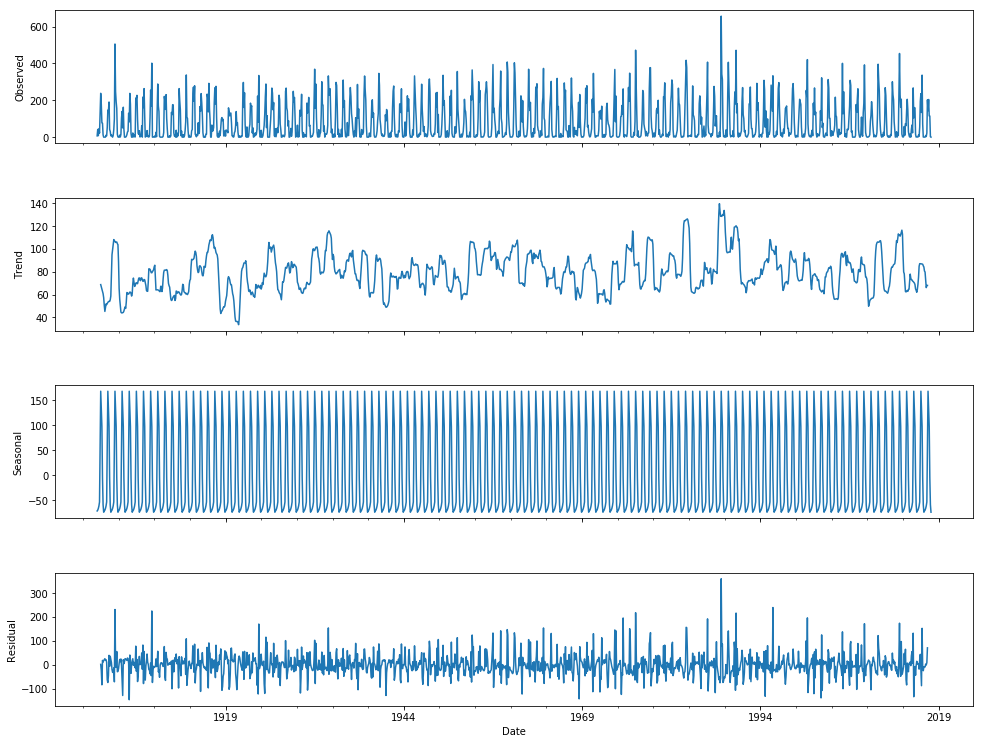

In [13]:
decomposition = seasonal_decompose(Tdf.Rainfall, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 12)

## Auto Correlation and Partial Corelation plots.

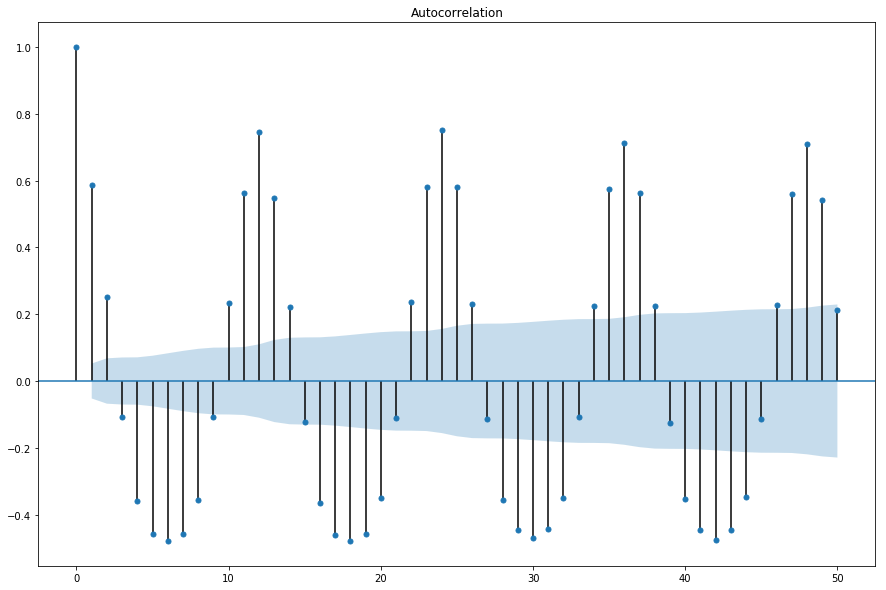

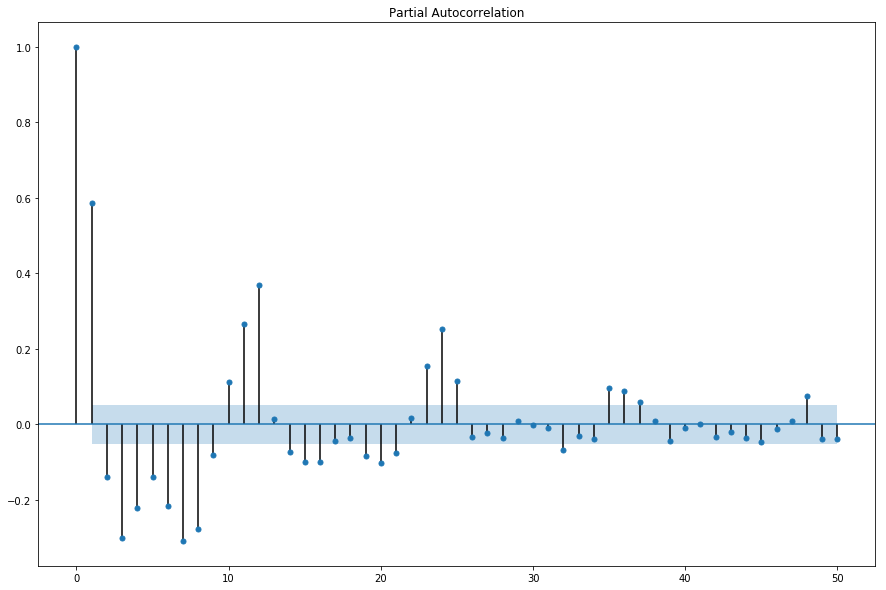

In [14]:
f_acf = plot_acf(Tdf['Rainfall'].dropna(), lags=50)
f_pacf = plot_pacf(Tdf['Rainfall'].dropna(), lags=50, method='ols')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)


## A little about AC and PAC


-  These Correlation plots tell us about the correlation between the latest point and the points that show up in the time period before.


-  Every relation has two components magnitude and direction.


-  The AC tells us about the direct and indirect correlation between two points in time.


-  The PAC tells us about only the direct correlation between two points in time.


-  All the values outside of the blue area are points that are statistically significant.


-  We can use these plots to further tune our parameters

# SARIMAX

#### Here we have used the SARIMAX model which is a seasonal variation of ARIMA(Auto Regressive integrated moving averages).

#### This method takes into account the seasonality of our data.

#### First we used a basic grid search and then by reading the AC and PAC we come to the final conclusion for our parameters for the SARIMAX model.

#### Next we make the prediction for the years 2018-2024 using data from 1988 and another from 1901.





## Grid Searching parameters for our SARIMAX Model

-  #### Trying out different combinations of 0 and 1 in place of 6 different parameters. The parameters take values higher than 1 as well but it tends to get computationally expensive.

-  #### We shall be using other methods that involve reading the AC and PAC chart to come up with values that are higher than 1 for our parameters.

-  #### For every model we calculate the AIC and pick the model with the lowest AIC.

-  #### This model with the lowest AIC will be our base model.

In [27]:
train=Tdf['Rainfall'].iloc[0:-60]
test=Tdf['Rainfall'].iloc[-60:]

In [ ]:
models=pd.DataFrame(check_AIC_BIC(train.dropna()))
modeled=models[models[2]==models[2].min()]
modeled.columns=['Order','Seasonal Order','AIC','BIC']
modeled

### Summary of our model

In [ ]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=False) 
model_fit.summary()

### Looking at the summary the parameters that are chosen show a p value less than 0.05 this means that they are statistically significant parameters.

## Reading the AC and PAC Charts

In [ ]:
model_b=SARIMAX(Tdf['Rainfall'],order=(3,1,0),seasonal_order=(3,1,0,12),enforce_stationarity=False,enforce_invertibility=False)
fitted_b=model_b.fit(disp=False)
fitted_b.summary()

### Similary we have included more parameters and all the p values of the parameters are lower than 0.05. This is a good fit.

### **We write a function to take in 4 parameters namely train,test,order and sorder. We apply this function in 4 different scenarios and see which scenario gives us the best result.**

#### Scenario 1:


-  Using the entirety of the data set along with the parameters from the grid search.


#### Scenario 2:


-  Using the entirety of the data set along with parameters obtained from reading the AC and PAC.


#### Scenario 3:


-  Using data from the year 1988 to 2012 and parameters from the grid search.


#### Scenario 4:


-  Using data from the year 1988 to 2012 and parameters obtained from reading the AC and PAC.




## Splitting the data into train and test and predicting.

### Scenario 1:

In [ ]:
trains1 = Tdf['Rainfall'].iloc[:-60]
tests1 =Tdf['Rainfall'].iloc[-60:]
orders1=(1,0,1)
sorders1=(1,1,1,12)

In [ ]:
SARIMAX_model(trains1,tests1,orders1,sorders1)

### Scenario 2:

In [ ]:
trains2 = Tdf['Rainfall'].iloc[:-60]
tests2 =Tdf['Rainfall'].iloc[-60:]
orders2=(3,1,0)
sorders2=(3,1,0,12)

In [ ]:
SARIMAX_model(trains2,tests2,orders2,sorders2)

### Scenario 3:

In [ ]:
trains3 = Tdf['Rainfall'].loc['1988-01-01':'2012-12-01']
tests3 =Tdf['Rainfall'].iloc[-60:]
orders3=(1,0,1)
sorders3=(1,1,1,12)

In [ ]:
SARIMAX_model(trains3,tests3,orders3,sorders3)

### Scenario 4:

In [ ]:
trains4 = Tdf['Rainfall'].loc['1988-01-01':'2012-12-01']
tests4 =Tdf['Rainfall'].iloc[-60:]
orders4=(3,1,0)
sorders4=(3,1,0,12)

In [ ]:
SARIMAX_model(trains4,tests4,orders4,sorders4)

-  **Next we decide which data set is more benefitial for our purpose.**


-  **The models that took into account all of the data points had a lower RMSE in general.**


-  **Hence we shall be considering all the data for making future prediction.**

## Final Forecast using the Grid Searched Parameters

In [ ]:
model_gs=SARIMAX(Tdf['Rainfall'],order=(1,0,1),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
fitted_gs=model_gs.fit(disp=False)
forecasts_gs=fitted_gs.forecast(84)
plt.figure(figsize=(12, 6))
plt.title('Rainfall Forecast', fontsize=30)
plt.plot((forecasts_gs), label='Forecast')
plt.show()

### In this model we have less variation but high bias.

In [ ]:
forecasts_gs.apply(replacer).resample('Y').sum()

## Final Forecast using the AC  and PAC Parameters

In [ ]:
model_b=SARIMAX(Tdf['Rainfall'],order=(3,1,0),seasonal_order=(3,1,0,12),enforce_stationarity=False,enforce_invertibility=False)
fitted_b=model_b.fit(disp=False)
forecasts_b=fitted_b.forecast(84)
plt.figure(figsize=(12, 6))
plt.title('Rainfall Forecast', fontsize=30)
plt.plot((forecasts_b), label='Forecast')
plt.show()

### This model we have a good mix of variance and bias. Although we do have some negative values. Now we will have to remove negative values as we cant have rain in real life that is negative.

In [ ]:
Final_Annual_Forecast=forecasts_b.apply(replacer).resample('Y').sum()

## Annual forecast!

In [ ]:
Final_Annual_Forecast

## Monthly Forecast

**I have introduced bias by reducing the overall values by a factor of 15 and by replacing values that are below 15 with 0. Hence removing any negative values.**

In [ ]:
forecasts_b.apply(replacer)

### The forecast using the AC and PAC parameters seems to be relatively robust and is closer to the truth than compared to the model we obtained by the grid search.

***

**Next we shall try a completely different method which is a relatively new method for forecasting time series data.**


## Fuzzy Time Series


**How does it work?:**


Our model takes numerical values converts them into multiple categorical variables and interprets the future categorical variables which it then converts back to numerical values.

### The Fuzzy time series uses multiple parameters to try and forecast future values.


#### Variations of the input parameters are below.



**Partitioner**= Grid.GridPartitioner,CMeans.CMeansPartitioner,FCM.FCMPartitioner,Entropy.EntropyPartitioner


**Method**= HighOrderFTS,WeightedHighOrderFTS,ProbabilisticWeightedFTS,chen.ConventionalFTS


**npart**= 10,20,30,40,50,100,200,300,400,500


**Order**= 1,2,3,4,5,6,7,8,9,10,11,12


**Batch_size**= 10,20,30,40,50,60,70,80,90,100


**Window_length**= 50,100,150,200,250,300,350,400,450,500

-  The two most important parameters for any model are "npart" and "order". They are the most significant as they tend to predicted scores drastically.



-  "Partitioner" and "method" are important  as well but they more or less converge to similar results.



-  "batch_size" and "window_length" dont have all that too much of an impact on the predictive capability of our model.

In [ ]:
FTS_train=np.array(Tdf['Rainfall'].iloc[:-60])
FTS_test=np.array(Tdf['Rainfall'].iloc[-60:])

In [ ]:
model1 = TimeVariant.Retrainer(
            partitioner_method=Grid.GridPartitioner,
            partitioner_params={'npart':10},
            fts_method=ProbabilisticWeightedFTS,
            fts_params={}, 
            order=5,
            batch_size=10,
            window_length=200)
model1.fit(FTS_train)
forecasts1=model1.predict(data=FTS_train,steps_ahead=60)
# forecasts1=np.array(forecasts1[:60])
fig=plt.figure(figsize=(12,6))
plt.plot(forecasts1,label='Forecasts')
plt.plot(FTS_test,label='Test')
plt.title('FuzzyTimeSeries Forecasting')
plt.legend(fontsize=25)
print(mean_squared_error(forecasts1,FTS_test),np.sqrt(mean_squared_error(forecasts1,FTS_test)),mean_absolute_error(forecasts1,FTS_test))

In [ ]:
forecasts1=pd.Series(forecasts1,test.index).apply(replacer)

In [ ]:
forecasts1.resample('Y').sum()

-  Here we notice that our forecast conforms to our test data much better. Although this is good we should be careful of overfitting the data as well as this could lead to unreliable future predictions.



-  Our prediction still doesnt take into account all of the outliers but it tends to mimic them to a certain extent. This means our model is relatively robust.



-  We can use this model to predict further into the future with better accuracy, without having the need of our test data to correct every step.

### Final forecast using Fuzzy Time Series.

In [ ]:
final_train=np.array(Tdf['Rainfall'])

In [ ]:
final_model = TimeVariant.Retrainer(
            partitioner_method=Grid.GridPartitioner,
            partitioner_params={'npart':10},
            fts_method=ProbabilisticWeightedFTS,
            fts_params={}, 
            order=5,
            batch_size=10,
            window_length=200)
final_model.fit(final_train)
final_forecast=final_model.predict(data=final_train,steps_ahead=84)

In [ ]:
final_index=pd.date_range('2018-01-01','2024-12-31',freq='M')

In [ ]:
final_forecast_replaced=pd.Series(final_forecast,index=final_index).apply(FTS_replacer)

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(final_forecast_replaced)
plt.title('FuzzyTimeSeries Forecasting')
plt.show()

### This is the final forecast using the Fuzzy Time Series for the years 2018-2024.

### We have introduced some bias in the model so as to conform to the actual results of 2018.

## Annual Forecast

In [ ]:
final_forecast_replaced.resample('Y').sum()

## Monthly Forecast

In [ ]:
final_forecast_replaced

## Conclusion:

I have tried and tested 2 different methods. **SARIMA** and **FuzzyTimeSeries**.
For **SARIMA** 4 different scenarios were tested. The most optimal of the 4 was used to make the predictions for the next 7 years.

For **FuzzyTimeSeries** i basically gridsearched through a number of parameters and converged towards the most optimal solution.
Using the final model forecasts for the next 7 years were obtained.

By observing the annual and monthly predictions of both methods.

-  The **SARIMA** method showed that the rainfall was in an overall gradual downward trend.

-  The **FuzzyTimeSeries** method showed a much more erratic distribution of the monthly and annual predictions. It did not seem to be able to predict the seasonality correctly.

The use of **LSTMs** and **GRUs** would provide a more accurate result provided the number of data points were more say the data was recorded on a daily basis.